# Audio Cats and Dogs

* **Dataset**: https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs

## Importar dependencias

In [28]:
import io 
import os
import wave
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import load_img, img_to_array, image_dataset_from_directory

## Configuración

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
base_path = '../datasets/cat-dogs-audio'

## Generar espectogramas, llevando audio a imagen

In [5]:
def generate_spectrograms(
   data_dir: str = f"{base_path}/data",
   output_dir: str = f"{base_path}/images",
   num_train: int = 200,
   num_test: int = 100
) -> None:
   os.makedirs(output_dir, exist_ok=True)
   train_dir = os.path.join(output_dir, "train")
   test_dir = os.path.join(output_dir, "test") 
   
   for split_dir in [train_dir, test_dir]:
       os.makedirs(split_dir, exist_ok=True)

   train_count = 0
   test_count = 0
       
   for dir_name in os.listdir(data_dir):
       current_dir = os.path.join(data_dir, dir_name)
       if not os.path.isdir(current_dir):
           continue
           
       for file in os.listdir(current_dir):
           if not file.endswith('.wav'):
               continue

           if train_count < num_train:
               output_base = train_dir
               train_count += 1
           elif test_count < num_test:
               output_base = test_dir 
               test_count += 1
           else:
               return

           number = file.split("_")[0]
           output_dir = os.path.join(output_base, number)
           os.makedirs(output_dir, exist_ok=True)
           
           with wave.open(os.path.join(current_dir, file), 'r') as f:
               fs = f.getframerate()
               wavebytes = np.frombuffer(f.readframes(-1), 'int16')
               
               plt.figure(figsize=(4, 4), dpi=100)
               plt.axis('off')
               plt.specgram(wavebytes, NFFT=256, Fs=fs)
               plt.savefig(
                   os.path.join(output_dir, file.replace(".wav", ".png")),
                   bbox_inches='tight', 
                   pad_inches=0
               )
               plt.close()

In [15]:
generate_spectrograms()

## Cargando datos

In [7]:
images_path = f"{base_path}/images/"
img_shape = (369, 496)

train = image_dataset_from_directory(os.path.join(images_path, "train"), image_size = img_shape)
test = image_dataset_from_directory(os.path.join(images_path, "test"), image_size = img_shape)

Found 200 files belonging to 2 classes.
Found 151 files belonging to 2 classes.


### Previsualizando los datos

2025-02-02 18:48:05.827286: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


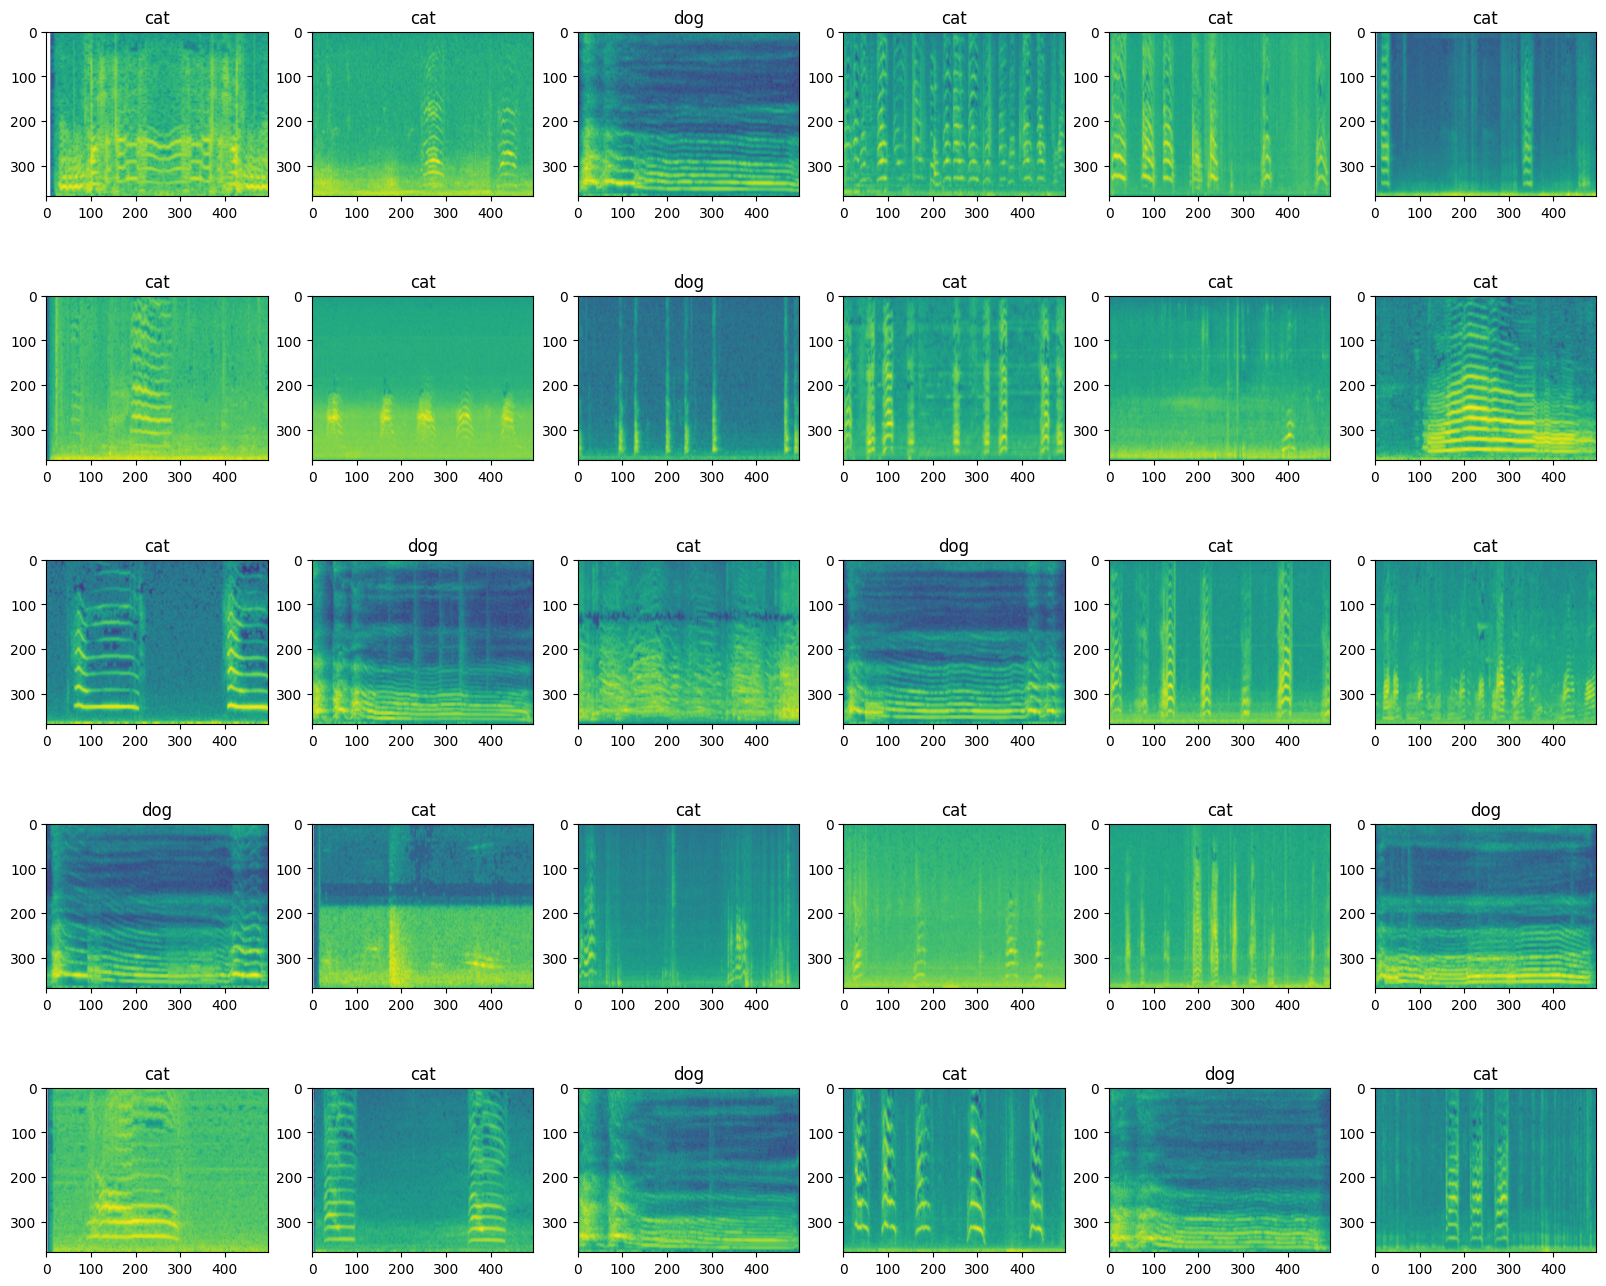

In [12]:
plt.figure(figsize=(20, 20))
for images, labels in train.take(1):
    for i in range(0, 30):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train.class_names[labels[i]])

## Arquitectura del modelo

In [41]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(369, 496, 3)),
    MaxPooling2D((3, 3)),        
    Dropout(0.1),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),        
    Dropout(0.1),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Dropout(0.1),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])
    
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 367, 494, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 122, 164, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 122, 164, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 120, 162, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 40, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 40, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 38, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 12, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 12, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 26112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    13,369,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,464,130 (51.36 MB)

 Trainable params: 13,464,130 (51.36 MB)

 Non-trainable params: 0 (0.00 B)

## Compilación y entrenamiento

In [42]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
result = model.fit(train, validation_data=test, epochs=70)

Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6157 - loss: 321.3661 - val_accuracy: 0.4901 - val_loss: 24.9012
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7596 - loss: 17.4255 - val_accuracy: 0.5629 - val_loss: 2.0544
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8443 - loss: 2.1010 - val_accuracy: 0.4901 - val_loss: 1.9489
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7600 - loss: 0.9399 - val_accuracy: 0.6623 - val_loss: 0.6302
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8554 - loss: 0.3264 - val_accuracy: 0.5099 - val_loss: 0.8006
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9080 - loss: 0.2575 - val_accuracy: 0.6358 - val_loss: 0.7490
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9235 - loss: 0.2737 - val_accuracy: 0.7219 - val_loss: 0.6669
Epoch 8/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9570 - loss: 0.1494 - val_accuracy: 0.8675 - val_loss: 0.4249
Epoc

## Comportamiento del entrenamiento

In [43]:
def plot_training_history(history, metric='accuracy', figsize=(10, 6)):
   plt.figure(figsize=figsize)
   
   plt.plot(history.history[metric], label='train')
   plt.plot(history.history[f'val_{metric}'], label='validation')
   
   plt.title(f'Model {metric}')
   plt.xlabel('Epoch')
   plt.ylabel(metric.capitalize())
   plt.legend(loc='upper left')
   plt.tight_layout()
   
   return plt.gcf()

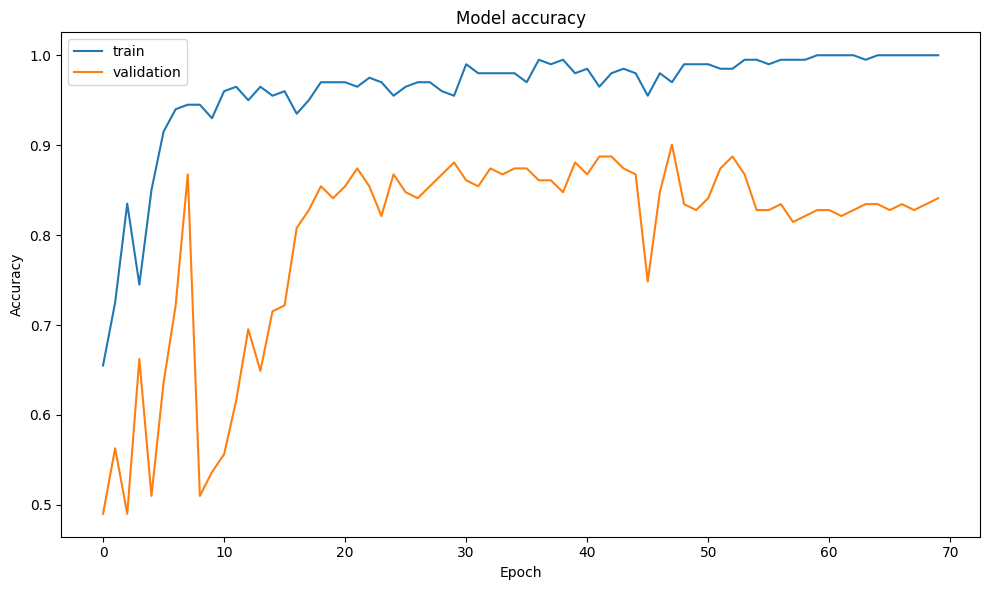

In [44]:
plot_training_history(result)
plt.show()

## Predicciones de comprobación

In [53]:
class_labels = ['cat', 'dog']

In [57]:
def predict_audio(audio_file_path, model):
  with wave.open(audio_file_path, 'r') as f:
      fs = f.getframerate()
      wavebytes = np.frombuffer(f.readframes(-1), 'int16')

      plt.figure(figsize=(4, 4), dpi=100)
      plt.axis('off')
      plt.specgram(wavebytes, NFFT=256, Fs=fs)
      
      temp_image_path = "temp_spectrogram.png"
      plt.savefig(temp_image_path, bbox_inches='tight', pad_inches=0)
      plt.close()

  img = load_img(temp_image_path, target_size=(369, 496))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  predictions = model.predict(img_array)
  predicted_class = class_labels[np.argmax(predictions[0])]

  os.remove(temp_image_path)

  return predicted_class

In [60]:
predicted_1 = predict_audio("../audio/cat_2.wav", model)
print(predicted_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
cat


In [61]:
predicted_2 = predict_audio("../audio/dog_barking_4.wav", model)
print(predicted_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
dog
